In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd /content/drive/MyDrive/Colab Notebooks/Data Mining Assignments/Clustering
!ls

/content/drive/MyDrive/Colab Notebooks/Data Mining Assignments/Clustering
Datasets	Plots
KMeans.ipynb	Run-and-Compare-Clustering-Algorithm-on-UCI-Datasets.ipynb
KMedoids.ipynb


In [26]:
!pip install ipynb

In [27]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.datasets import load_iris, load_digits, load_wine
from ipynb.fs.full.KMeans import KMeansClustering
from ipynb.fs.full.KMedoids import KMedoidsClustering

plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plotStyles = {
    'markers' : ["o","^","*","p","s","X","d"],
    'color' : ['#22a6b3','#30336b','#00cec9', '#0984e3',  '#6c5ce7' , '#00b894','#74b9ff', '#d63031', '#273c75',   '#74b9ff'],
    'lineStyle' : 'solid',
    'markerSize' :  10,
  }

## Algorithm Directory path

In [28]:
# All the datasets are loaded from this directory and
# All the results are stored in this directory
directoryPath = '/content/drive/MyDrive/Colab Notebooks/Data Mining Assignments/Clustering/'

## Clustering

In [29]:
def elbow_method(X, Y, maxK, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5):
  kMeansVariance, kMedoidsVariance = np.array([]), np.array([])
  kMeansSilhouette, kMedoidsSilhouette = np.array([]), np.array([])
  kMeansPrecision, kMedoidsPrecision = np.array([]), np.array([])
  kMeansRecall, kMedoidsRecall = np.array([]), np.array([])
  for K in range(2, maxK+1):
    kMeans = KMeansClustering(X, Y, K, dataType, attributeTypes, ranks, numberOfIterations)
    kMeans.train()
    kMeansVariance = np.append(kMeansVariance, kMeans.get_withinClusterVariance())
    kMeansSilhouette = np.append(kMeansSilhouette, kMeans.get_silhouetteCoefficient())
    kMeansPrecision = np.append(kMeansPrecision, kMeans.get_BCubedPrecision())
    kMeansRecall = np.append(kMeansRecall, kMeans.get_BCubedRecall())

    kMedoids = KMedoidsClustering(X, Y, K, dataType, attributeTypes, ranks, numberOfIterations)
    kMedoids.train()
    kMedoidsVariance = np.append(kMedoidsVariance, kMedoids.get_withinClusterVariance())
    kMedoidsSilhouette = np.append(kMedoidsSilhouette, kMedoids.get_silhouetteCoefficient())
    kMedoidsPrecision = np.append(kMedoidsPrecision, kMedoids.get_BCubedPrecision())
    kMedoidsRecall = np.append(kMedoidsRecall, kMedoids.get_BCubedRecall())

  measures = {
      'Variance': {
          'KMeans' : kMeansVariance,
          'KMedoids': kMedoidsVariance
      },
      'Silhouette_Coefficient': {
          'KMeans' : kMeansSilhouette,
          'KMedoids': kMedoidsSilhouette
      },
      'BCubed_Precision': {
          'KMeans' : kMeansPrecision,
          'KMedoids': kMedoidsPrecision
      },
      'BCubed_Recall': {
          'KMeans' : kMeansRecall,
          'KMedoids': kMedoidsRecall
      }
  }

  return measures

In [30]:
def plot_cluster(dName, methodName, X, K, clusterCenters, clusterLabels, fileExtension = "png"):
  plt.clf()
  color = ["red","green", "blue", "yellow", "coral", "teal", "cyan", "brown","black"]
  for k in range(K):
      plt.scatter(X[clusterLabels == k, 0], X[clusterLabels == k, 1], color=color[k])
  
  # print(clusterCenters)
  
  plt.scatter(clusterCenters[:, 0] , clusterCenters[:, 1], color="black")
  plt.savefig('{}/Plots/{}_cluster_{}.{}'.format(directoryPath, dName, methodName,fileExtension))

In [31]:
def clustering(X, Y, bestK, dName, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5):
  
  kMeans = KMeansClustering(X, Y, bestK, dataType, attributeTypes, ranks, numberOfIterations)
  kMeans.train()
  if X.shape[1] == 2:
    plot_cluster(dName, 'kMeans',kMeans.normalize_numerical_values(X), bestK, kMeans.clusterCenters["numerical"], kMeans.clusterLabels)
  kMeansMeasures = [kMeans.get_withinClusterVariance(), kMeans.get_silhouetteCoefficient(), kMeans.get_BCubedPrecision(), kMeans.get_BCubedRecall()]

  kMedoids = KMedoidsClustering(X, Y, bestK, dataType, attributeTypes, ranks, numberOfIterations)
  kMedoids.train()
  if X.shape[1] == 2:
    scaledX = kMedoids.normalize_numerical_values(X)
    plot_cluster(dName, 'kMedoids',scaledX, bestK, scaledX[kMedoids.representativeObjectsIdx, :], kMedoids.clusterLabels)
  kMedoidsMeasures = [kMedoids.get_withinClusterVariance(), kMedoids.get_silhouetteCoefficient(), kMedoids.get_BCubedPrecision(), kMedoids.get_BCubedRecall()]
  
  print("Measures : [Variance SilhouetteCoefficient Precision Recall]")
  print("KMeans :", kMeansMeasures)
  print("KMedoids :", kMedoidsMeasures)

  return kMeansMeasures, kMedoidsMeasures
  

In [32]:
def plot_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK, dName):
  barWidth = 0.25
  fig = plt.subplots(figsize =(12, 8)) 
    
  # Set position of bar on X axis 
  br1 = np.arange(len(kMeansMeasures)) 
  br2 = [x + barWidth for x in br1] 
  
  plt.title('Dataset: {} and Number of Clusters: {}'.format(dName, bestK), fontsize=20)
  # Make the plot 
  p1 = plt.bar(br1, kMeansMeasures, color ='#778beb', width = barWidth, 
          edgecolor ='grey', label ='KMeans') 
  p2 = plt.bar(br2, kMedoidsMeasures, color ='#303952', width = barWidth, 
          edgecolor ='grey', label ='KMedoids') 
    
  # Adding Xticks 
  # plt.ylim(0,1.2) 
  plt.xlabel('Measure Names', fontweight ='bold', fontsize=20) 
  plt.ylabel('Score', fontweight ='bold', fontsize=20) 
  plt.xticks([r + barWidth for r in range(len(kMeansMeasures))], 
            ['Variance', 'Silhouette Coefficient', 'BCubed Precision', 'BCubed Recall']) 
  
  plt.legend((p1[0], p2[0]), ('KMeans' ,'KMedoids'), prop={'size': 15})
    
  plt.show() 

In [33]:
def save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK, dName, fileExtension = 'svg'):
  barWidth = 0.25
  fig = plt.subplots(figsize =(12, 8)) 
    
  # Set position of bar on X axis 
  br1 = np.arange(len(kMeansMeasures)) 
  br2 = [x + barWidth for x in br1] 
  
  plt.title('Dataset: {} and Number of Clusters: {}'.format(dName, bestK), fontsize=20)
  # Make the plot 
  p1 = plt.bar(br1, kMeansMeasures, color ='#778beb', width = barWidth, 
          edgecolor ='grey', label ='KMeans') 
  p2 = plt.bar(br2, kMedoidsMeasures, color ='#303952', width = barWidth, 
          edgecolor ='grey', label ='KMedoids') 
    
  # Adding Xticks  
  # plt.ylim(0,1.2)
  plt.xlabel('Measure Names', fontweight ='bold', fontsize=20) 
  plt.ylabel('Score', fontweight ='bold', fontsize=20) 
  plt.xticks([r + barWidth for r in range(len(kMeansMeasures))], 
            ['Variance', 'Silhouette Coefficient', 'BCubed Precision', 'BCubed Recall']) 
  
  plt.legend((p1[0], p2[0]), ('KMeans' ,'KMedoids'), prop={'size': 15})
    
  plt.savefig('{}/Plots/{}.{}'.format(directoryPath, dName, fileExtension))


In [34]:
def plot_elbow_curve(dName, measures, maxK):

  extension = ['Variance', 'Silhouette_Coefficient', 'BCubed_Precision', 'BCubed_Recall']
  plt.figure(figsize=(10*len(extension),10))

  for i in range(len(extension)):
    methods = ['KMeans', 'KMedoids']
    noOfMethods = len(methods)    
    
    plt.subplot(1, len(extension), i + 1).set_title('Dataset: {}'.format(dName), fontsize=20)
    lines = []
    labels = []
    for j in range(noOfMethods):
      value = measures[extension[i]][methods[j]]
      if extension[i] == 'Variance':
        plt.ylabel('1/Variance', fontsize=20)
        value = 1/value
      elif extension[i] == 'Silhouette_Coefficient':
        plt.ylabel('Silhouette Coefficient', fontsize=20)
      elif extension[i] == 'BCubed_Precision':
        plt.ylabel('BCubed Precision', fontsize=20)
      else:
        plt.ylabel('BCubed Recall', fontsize=20)

      plt.xlabel('Number of Clusters (K)', fontsize=20)

      line,  = plt.plot(np.arange(2, maxK+1), value, color=plotStyles['color'][j], linestyle=plotStyles['lineStyle'], 
      marker=plotStyles['markers'][j], markersize=plotStyles['markerSize'], label=methods[j])
      labels.append(methods[j])
      lines.append(line)

    plt.legend(lines, labels, prop={'size': 18})      
  plt.show()

In [35]:
def save_elbow_curve(dName, measures, maxK, fileExtension='svg'):
  extension = ['Variance', 'Silhouette_Coefficient', 'BCubed_Precision', 'BCubed_Recall']
  plt.figure(figsize=(10,10))

  for i in range(len(extension)):
    methods = ['KMeans', 'KMedoids']
    noOfMethods = len(methods)    
    
    plt.clf()
    plt.title('Dataset: {}'.format(dName), fontsize=20)
    lines = []
    labels = []
    for j in range(noOfMethods):
      value = measures[extension[i]][methods[j]]
      if extension[i] == 'Variance':
        plt.ylabel('1/Variance', fontsize=20)
        value = 1/value
      elif extension[i] == 'Silhouette_Coefficient':
        plt.ylabel('Silhouette Coefficient', fontsize=20)
      elif extension[i] == 'BCubed_Precision':
        plt.ylabel('BCubed Precision', fontsize=20)
      else:
        plt.ylabel('BCubed Recall', fontsize=20)

      plt.xlabel('Number of Clusters (K)', fontsize=20)

      line,  = plt.plot(np.arange(2, maxK+1), value, color=plotStyles['color'][j], linestyle=plotStyles['lineStyle'], 
      marker=plotStyles['markers'][j], markersize=plotStyles['markerSize'], label=methods[j])
      labels.append(methods[j])
      lines.append(line)

    plt.legend(lines, labels, prop={'size': 18})            
    plt.savefig('{}/Plots/{}-{}.{}'.format(directoryPath, dName, extension[i], fileExtension))

## Iris

dataset: iris
instances = 150, features= 4 


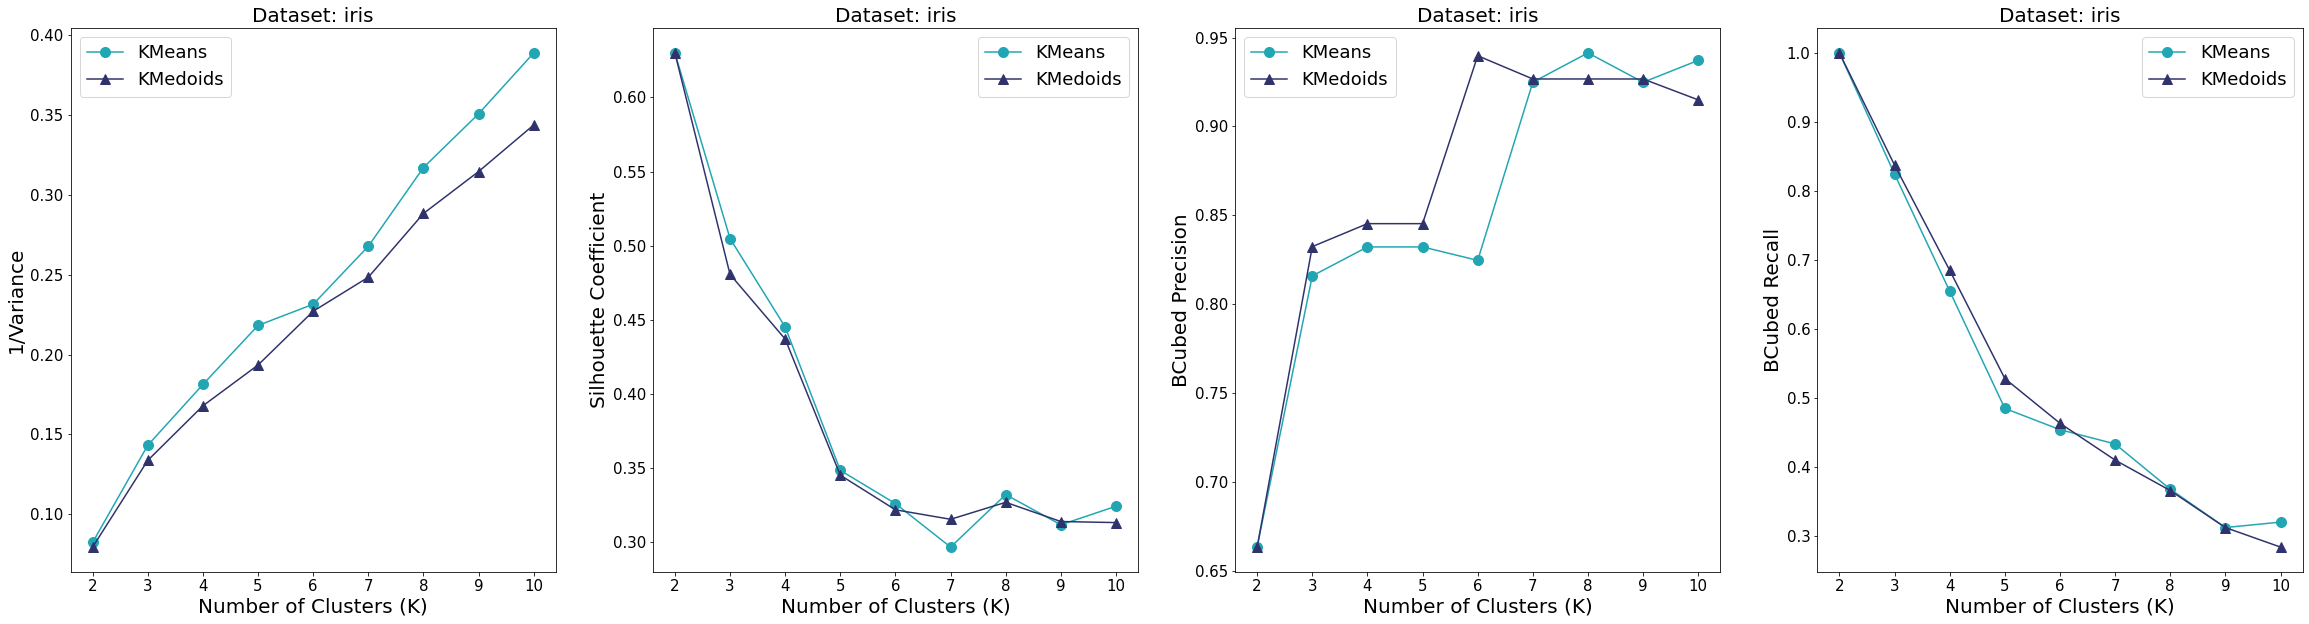

In [36]:
dName = 'iris'
X, Y = load_iris(return_X_y= True)
Y = np.squeeze(Y)
print('dataset: iris')
# print(X,Y)
print('instances = {}, features= {} '.format(X.shape[0], X.shape[1]))
measures = elbow_method(X, Y, maxK = 10, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
plot_elbow_curve(dName, measures, maxK = 10)
# save_elbow_curve(dName, measures, maxK = 10, fileExtension='svg')
# save_elbow_curve(dName, measures, maxK = 10, fileExtension='png')

In [37]:
kMeansMeasures, kMedoidsMeasures = clustering(X, Y, bestK = 4,dName = dName, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK=3, dName = dName)
# save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'svg')
# save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'png')

Measures : [Variance SilhouetteCoefficient Precision Recall]
KMeans : [5.51693347204037, 0.4450654880459854, 0.832171893147503, 0.6549659863945565]
KMedoids : [5.955614539776776, 0.43692037595074784, 0.8452698412698432, 0.685170068027209]


## Wine

dataset: wine
instances = 178, features= 13 


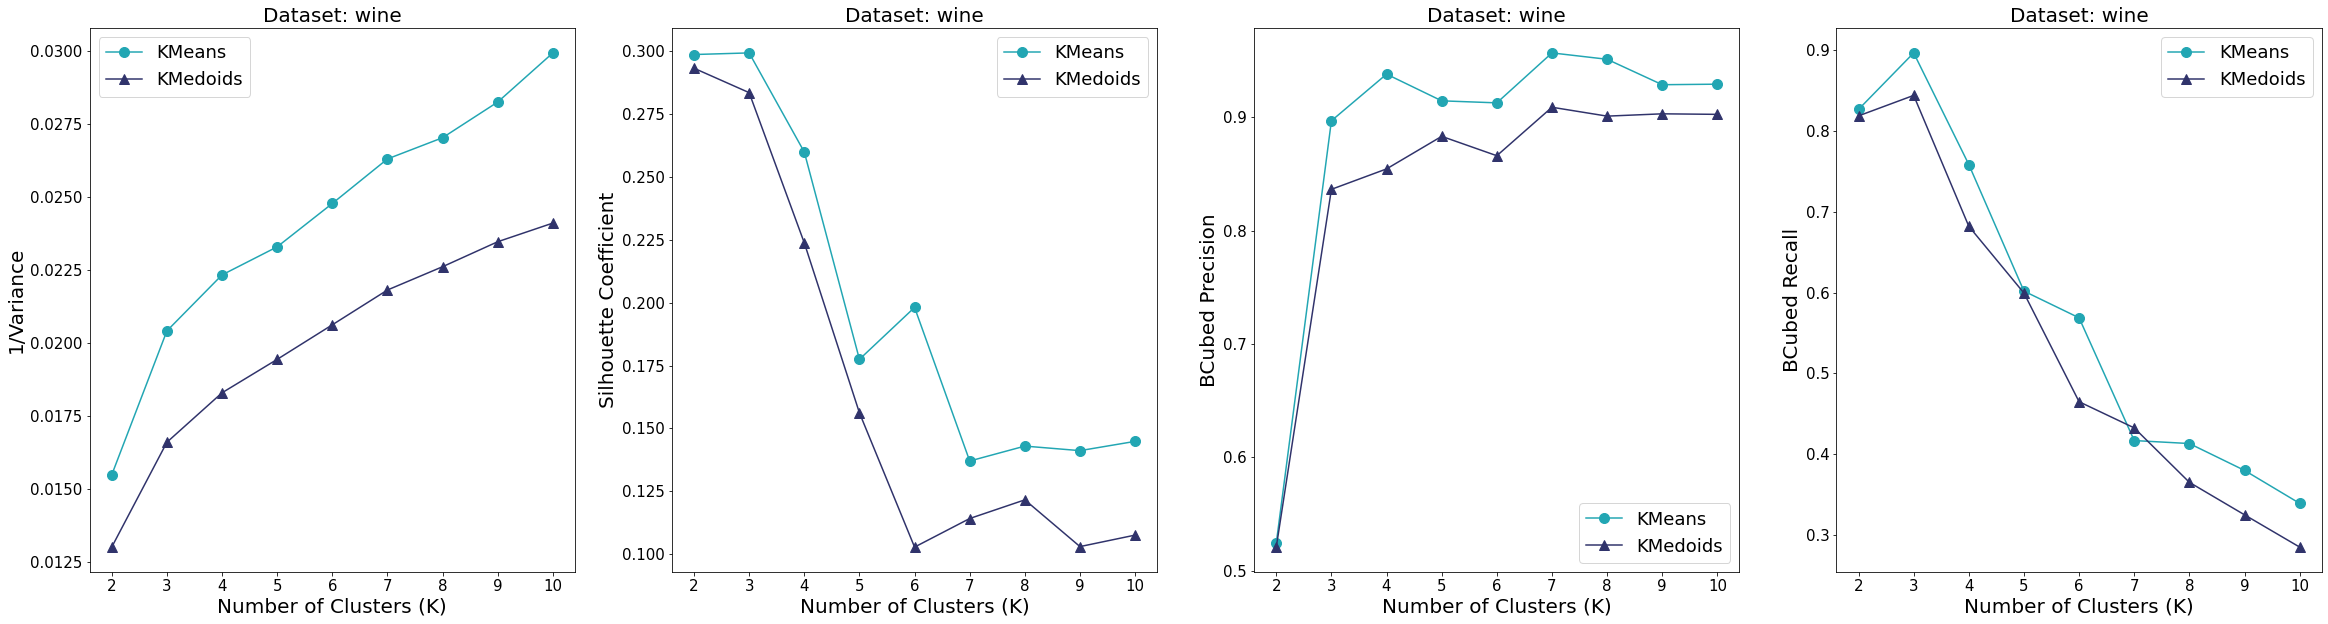

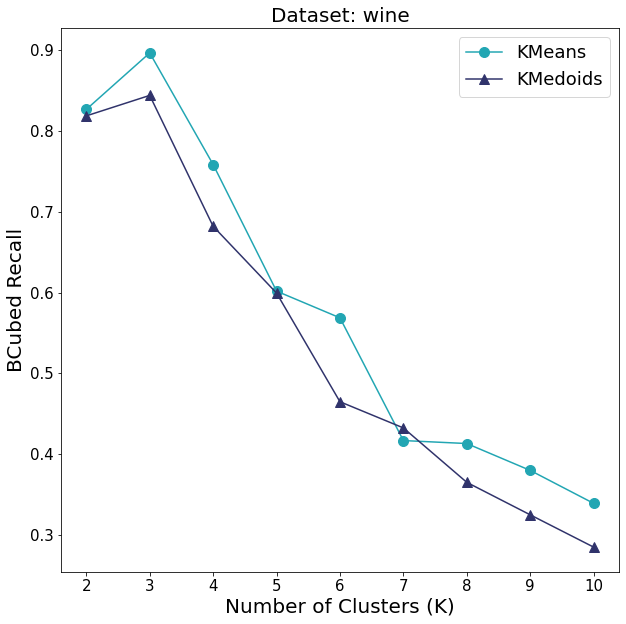

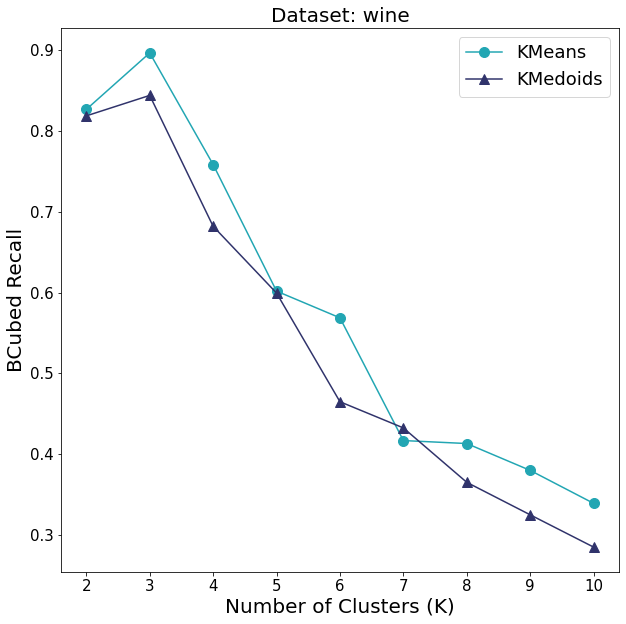

In [ ]:
# dName = "wine"
# X, Y = load_wine(return_X_y= True)
# Y = np.squeeze(Y)
# print('dataset: wine')
# # print(X,Y)
# print('instances = {}, features= {} '.format(X.shape[0], X.shape[1]))

# measures = elbow_method(X, Y, maxK = 10, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_elbow_curve(dName, measures, maxK = 10)
# save_elbow_curve(dName, measures, maxK = 10, fileExtension='svg')
# save_elbow_curve(dName, measures, maxK = 10, fileExtension='png')

In [ ]:
# kMeansMeasures, kMedoidsMeasures = clustering(X, Y, bestK = 3, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK=3, dName = dName)
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'svg')
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'png')

## Travel Review

dataset: travel_review
instances = 980, features= 10 


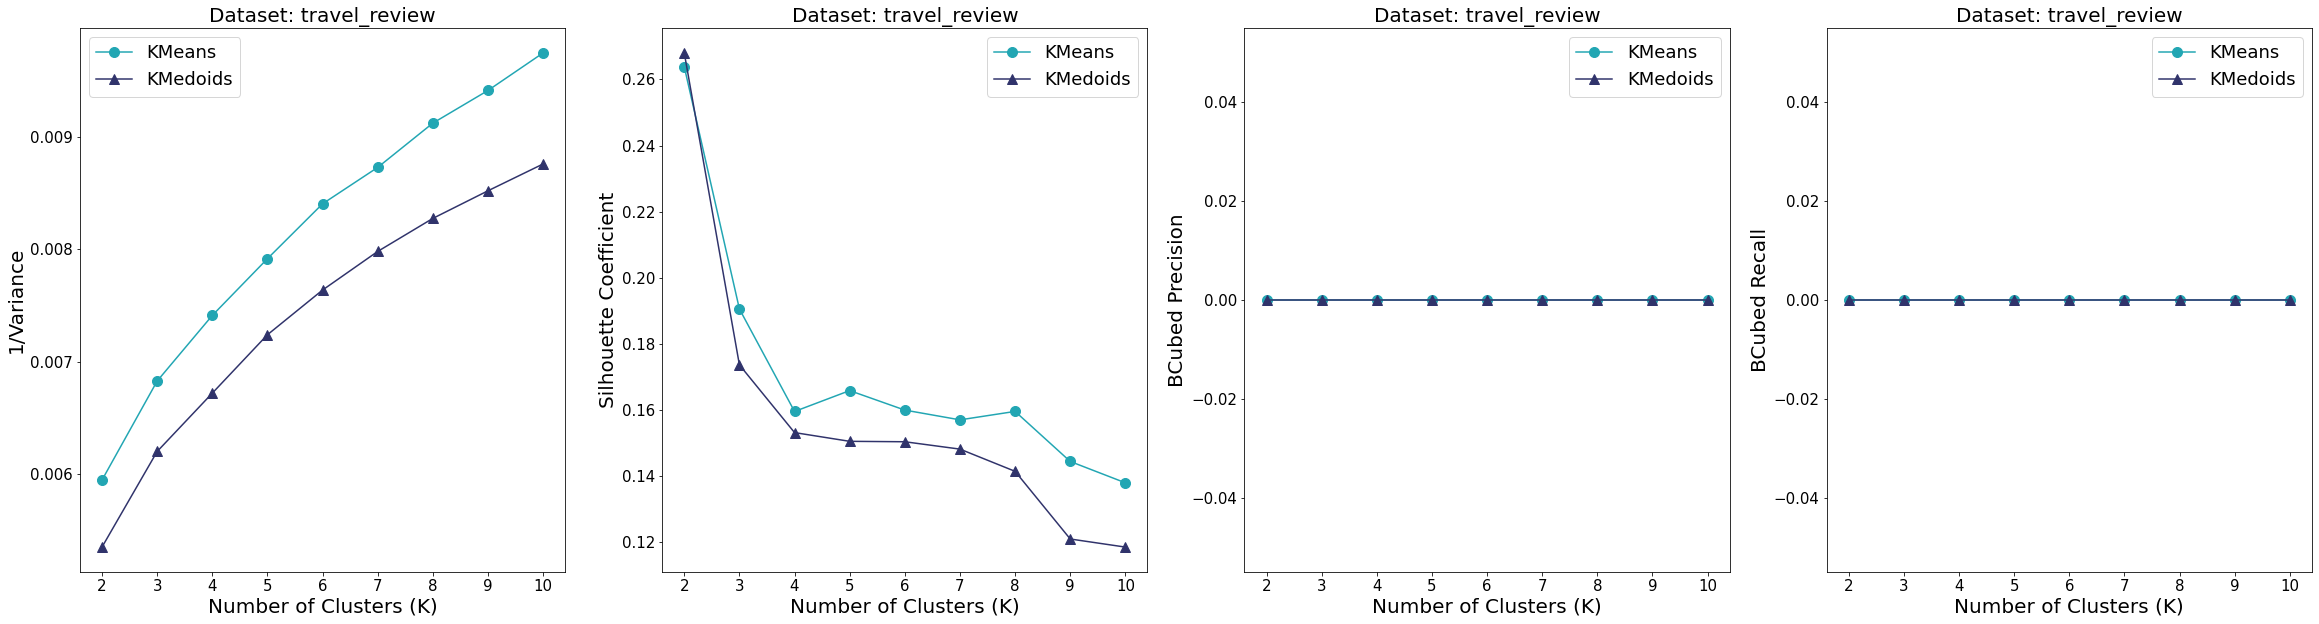

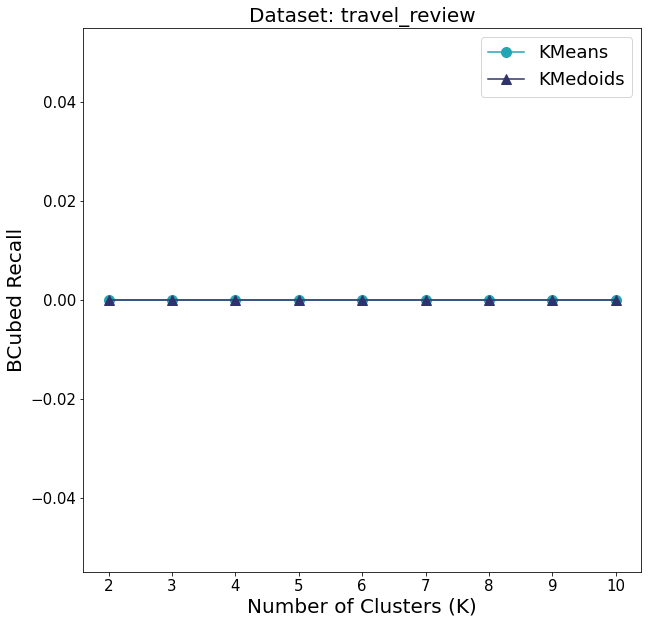

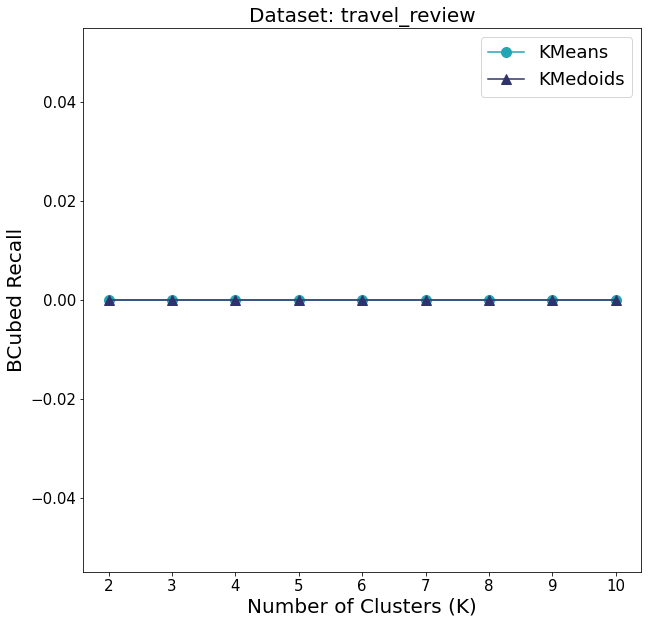

In [ ]:
# dName = "travel_review"
# df = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/Data Mining Assignments/Clustering/Datasets/travel_review.csv', sep=',',header=0)
# X_df = df.iloc[:,1:]
# print('dataset: travel_review')
# # print(X_df.head())
# # print(Y_df.head())
# print('instances = {}, features= {} '.format(X_df.shape[0], X_df.shape[1]))

# X = X_df.fillna(X_df.mean()).to_numpy() 
# Y = np.array([])
# # print(X, Y)

# measures = elbow_method(X, Y, maxK = 10, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_elbow_curve(dName, measures, maxK = 10)
# save_elbow_curve(dName, measures, maxK = 10, fileExtension='svg')
# save_elbow_curve(dName, measures, maxK = 10, fileExtension='png')

In [ ]:
# kMeansMeasures, kMedoidsMeasures = clustering(X, Y, bestK = 3, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK=3, dName = dName)
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'svg')
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'png')

## Glass

dataset: glass
instances = 214, features= 9 


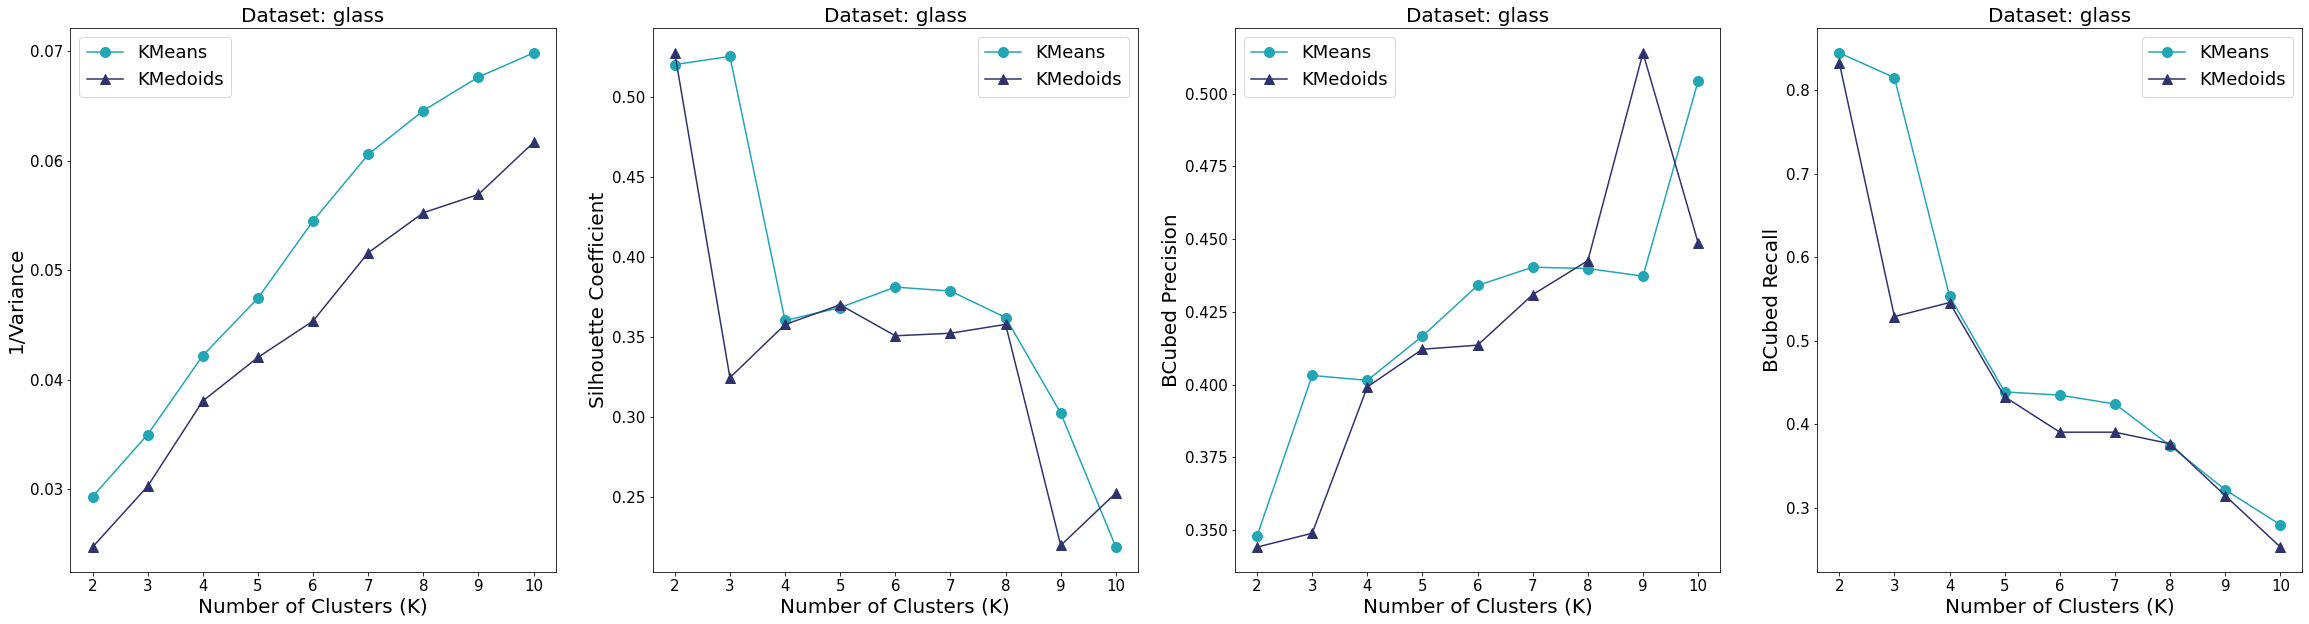

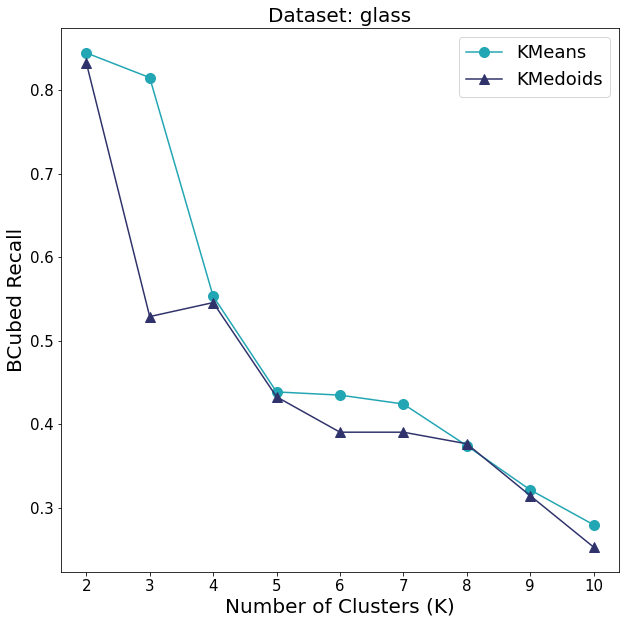

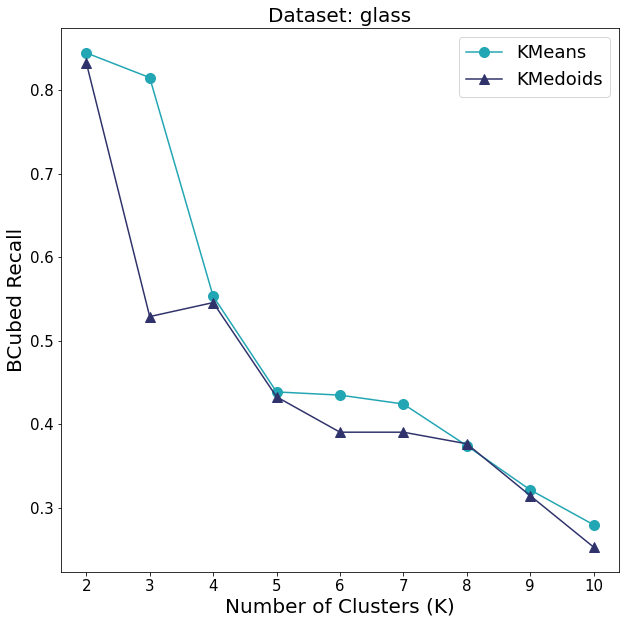

In [ ]:
# dName = "glass"
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Mining Assignments/Clustering/Datasets/glass.csv', sep=",",header=None)
# X_df = df.iloc[:,1:-1]
# Y_df = df.iloc[:,-1]
# print('dataset: glass')
# # print(X_df.head())
# # print(Y_df.head())
# print('instances = {}, features= {} '.format(X_df.shape[0], X_df.shape[1]))

# X = X_df.fillna(X_df.mean()).to_numpy() 
# Y = np.squeeze(Y_df.to_numpy())

# measures = elbow_method(X, Y, maxK = 10, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_elbow_curve(dName, measures, maxK = 10)
# save_elbow_curve(dName, measures, maxK = 10, fileExtension='svg')
# save_elbow_curve(dName, measures, maxK = 10, fileExtension='png')

In [ ]:
# kMeansMeasures, kMedoidsMeasures = clustering(X, Y, bestK = 3, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK=3, dName = dName)
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'svg')
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'png')

## Aggregation

dataset: aggregation
instances = 788, features= 2 


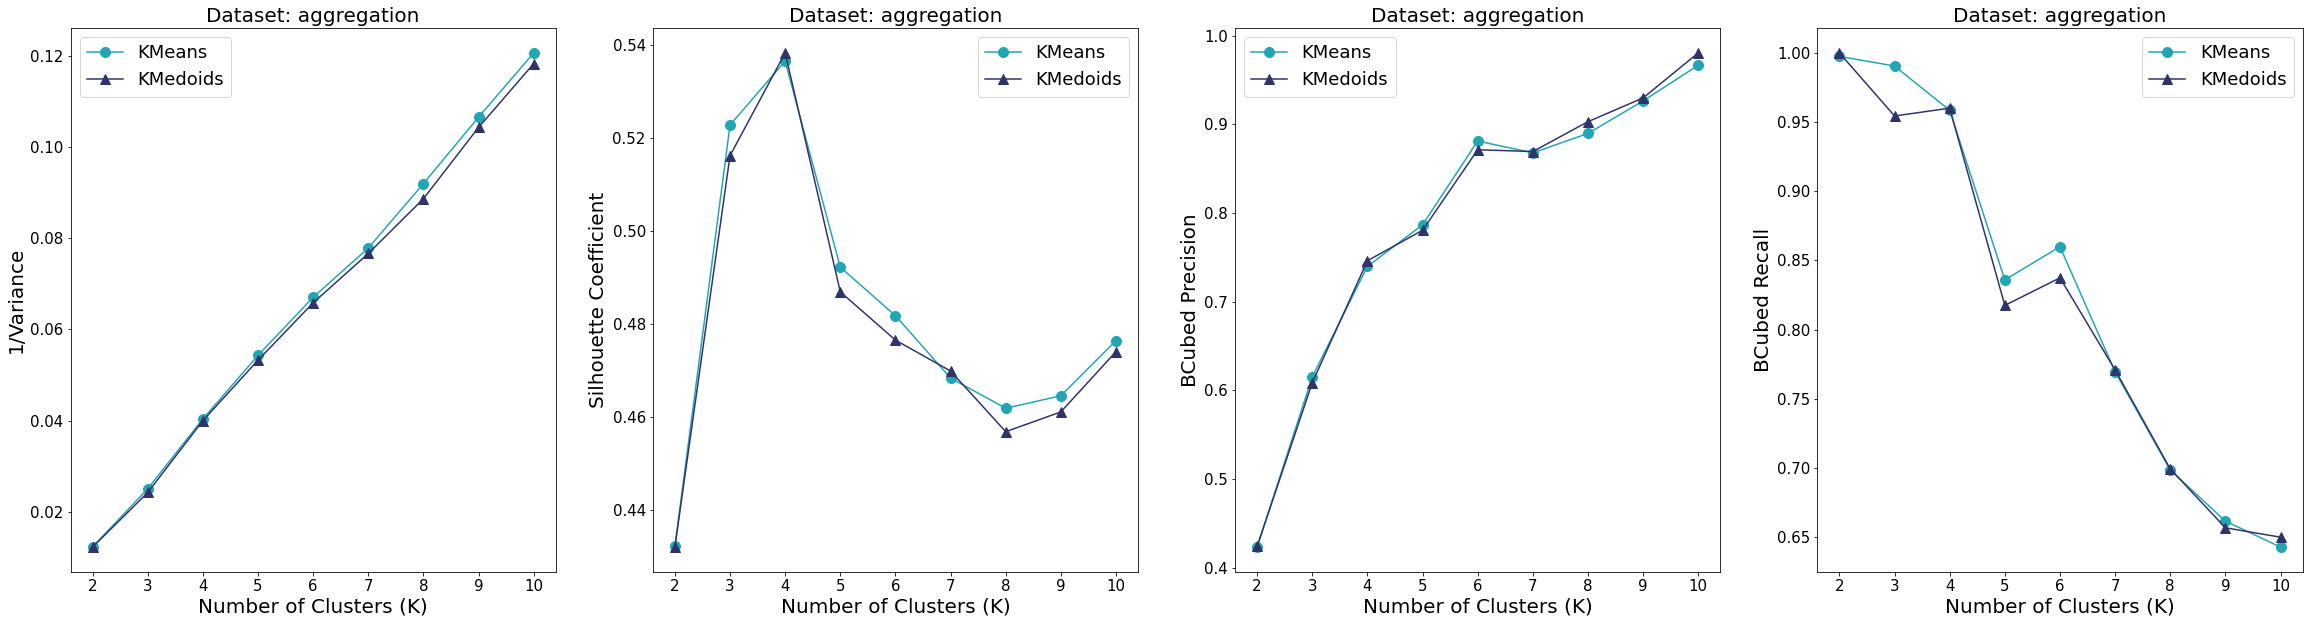

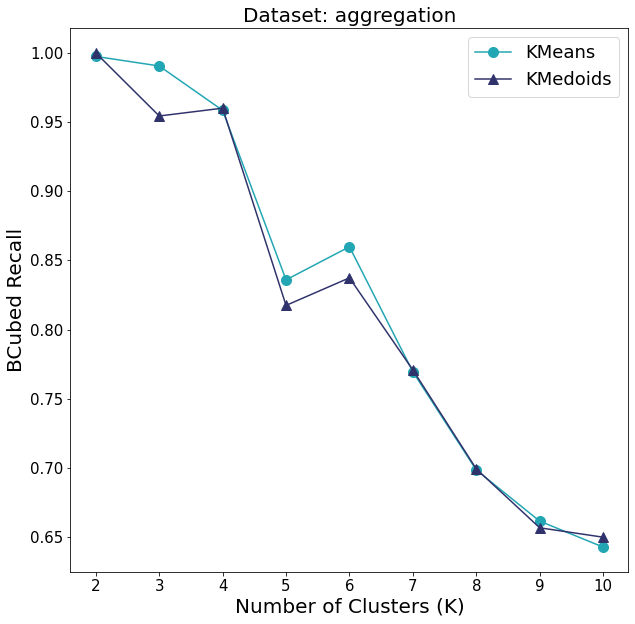

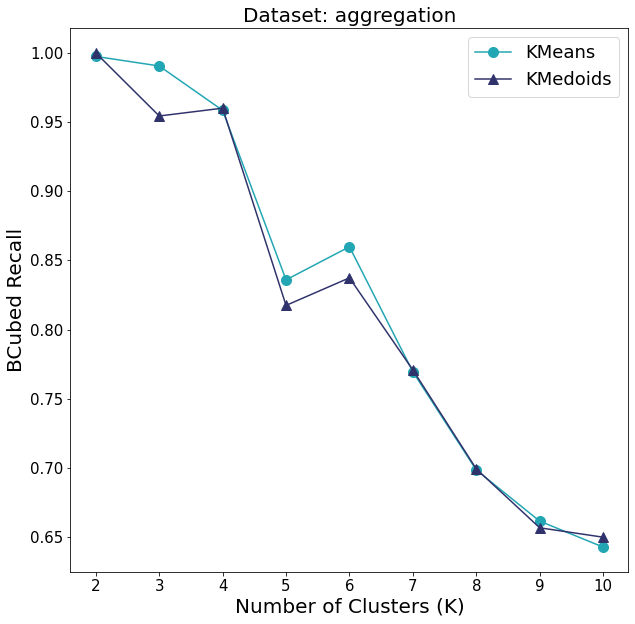

In [ ]:
# dName = "aggregation"
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Mining Assignments/Clustering/Datasets/aggregation.csv', sep=",",header=None)
# X_df = df.iloc[:,:-1]
# Y_df = df.iloc[:,-1]
# print('dataset: aggregation')
# # print(X_df.head())
# # print(Y_df.head())
# print('instances = {}, features= {} '.format(X_df.shape[0], X_df.shape[1]))

# X = X_df.fillna(X_df.mean()).to_numpy() 
# Y = np.squeeze(Y_df.to_numpy())

# measures = elbow_method(X, Y, maxK = 10, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_elbow_curve(dName, measures, maxK = 10)
# save_elbow_curve(dName, measures, maxK = 10, fileExtension='svg')
# save_elbow_curve(dName, measures, maxK = 10, fileExtension='png')

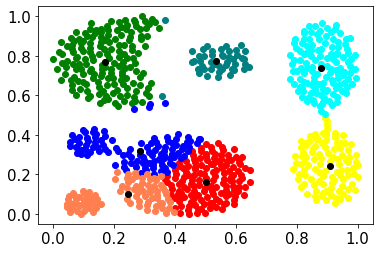

In [ ]:
# kMeansMeasures, kMedoidsMeasures = clustering(X, Y, bestK = 7, dName = dName, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 10)

In [ ]:
# kMeansMeasures, kMedoidsMeasures = clustering(X, Y, bestK = 3, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK=3, dName = dName)
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'svg')
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'png')

In [ ]:
# kMeansMeasures, kMedoidsMeasures = clustering(X, Y, bestK = 3, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK=3, dName = dName)
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'svg')
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'png')

## Breast Tissue

dataset: breast_tissue
instances = 106, features= 9 


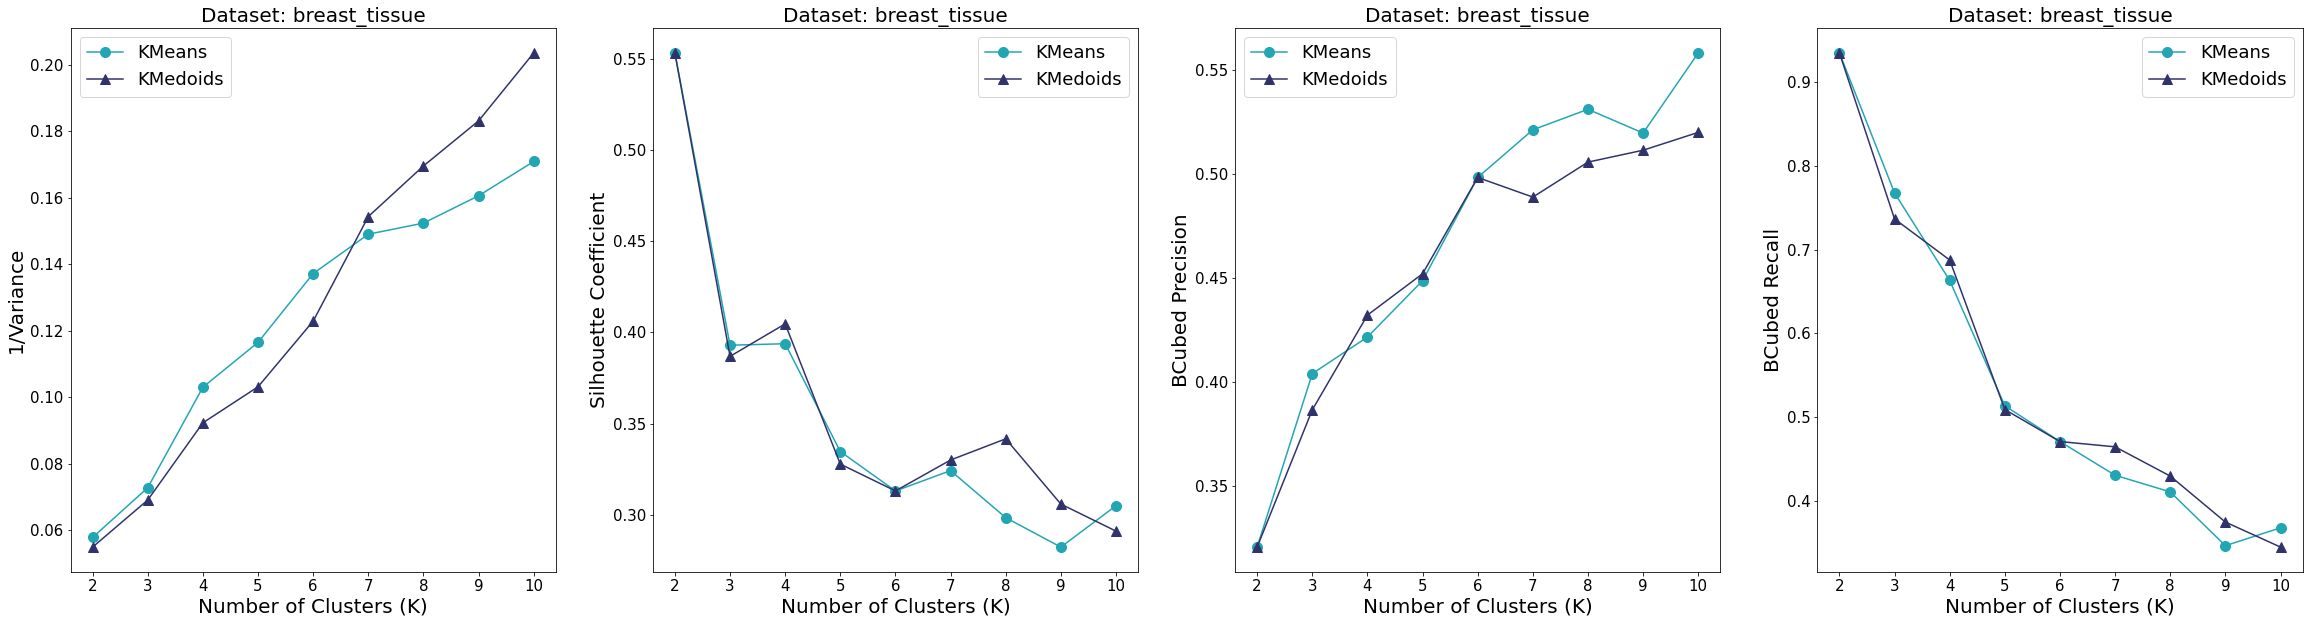

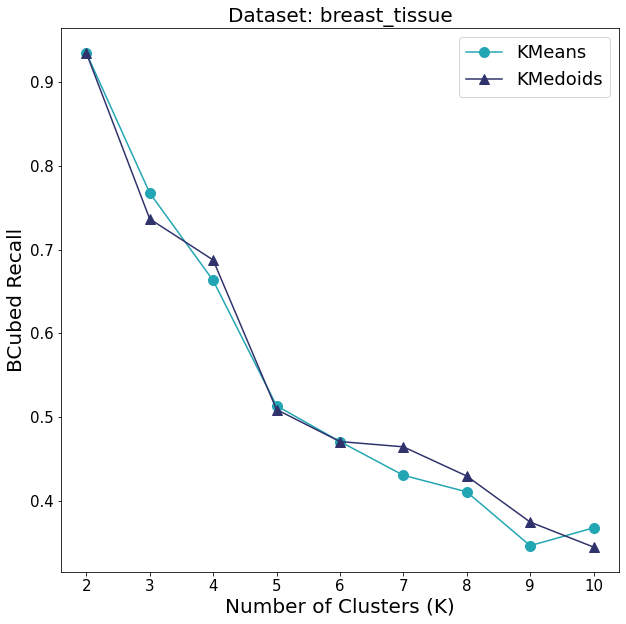

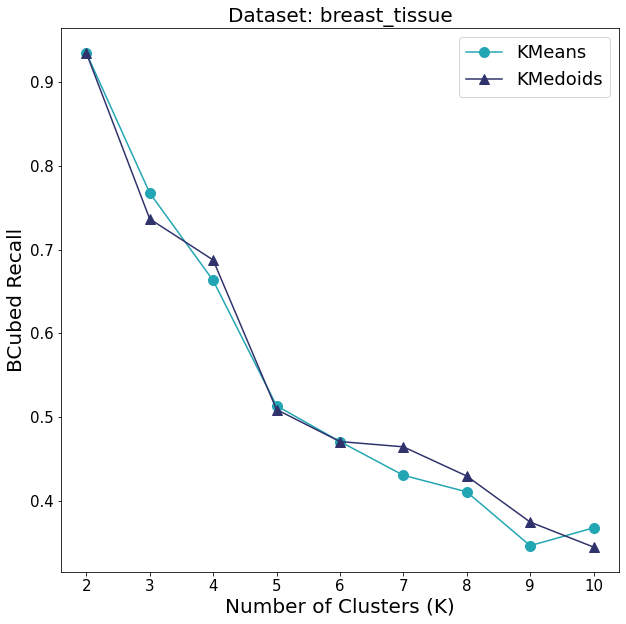

In [ ]:
dName = "breast_tissue"
df = pd.read_excel('/content/drive/My Drive/Thesis/Datasets/BreastTissue/BreastTissue.xls', sheet_name='Data')
X_df = df.iloc[:, 1:-1]
Y_df = df.iloc[:,-1]
print('dataset: breast_tissue')
# print(X_df.head())
# print(Y_df.head())
print('instances = {}, features= {} '.format(X_df.shape[0], X_df.shape[1]))

X = X_df.fillna(X_df.mean()).to_numpy() 
Y = np.squeeze(Y_df.to_numpy())

measures = elbow_method(X, Y, maxK = 10, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
plot_elbow_curve(dName, measures, maxK = 10)
save_elbow_curve(dName, measures, maxK = 10, fileExtension='svg')
save_elbow_curve(dName, measures, maxK = 10, fileExtension='png')

In [ ]:
# kMeansMeasures, kMedoidsMeasures = clustering(X, Y, bestK = 3, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK=3, dName = dName)
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'svg')
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'png')

## Ecoli

dataset: ecoli
instances = 336, features= 7 


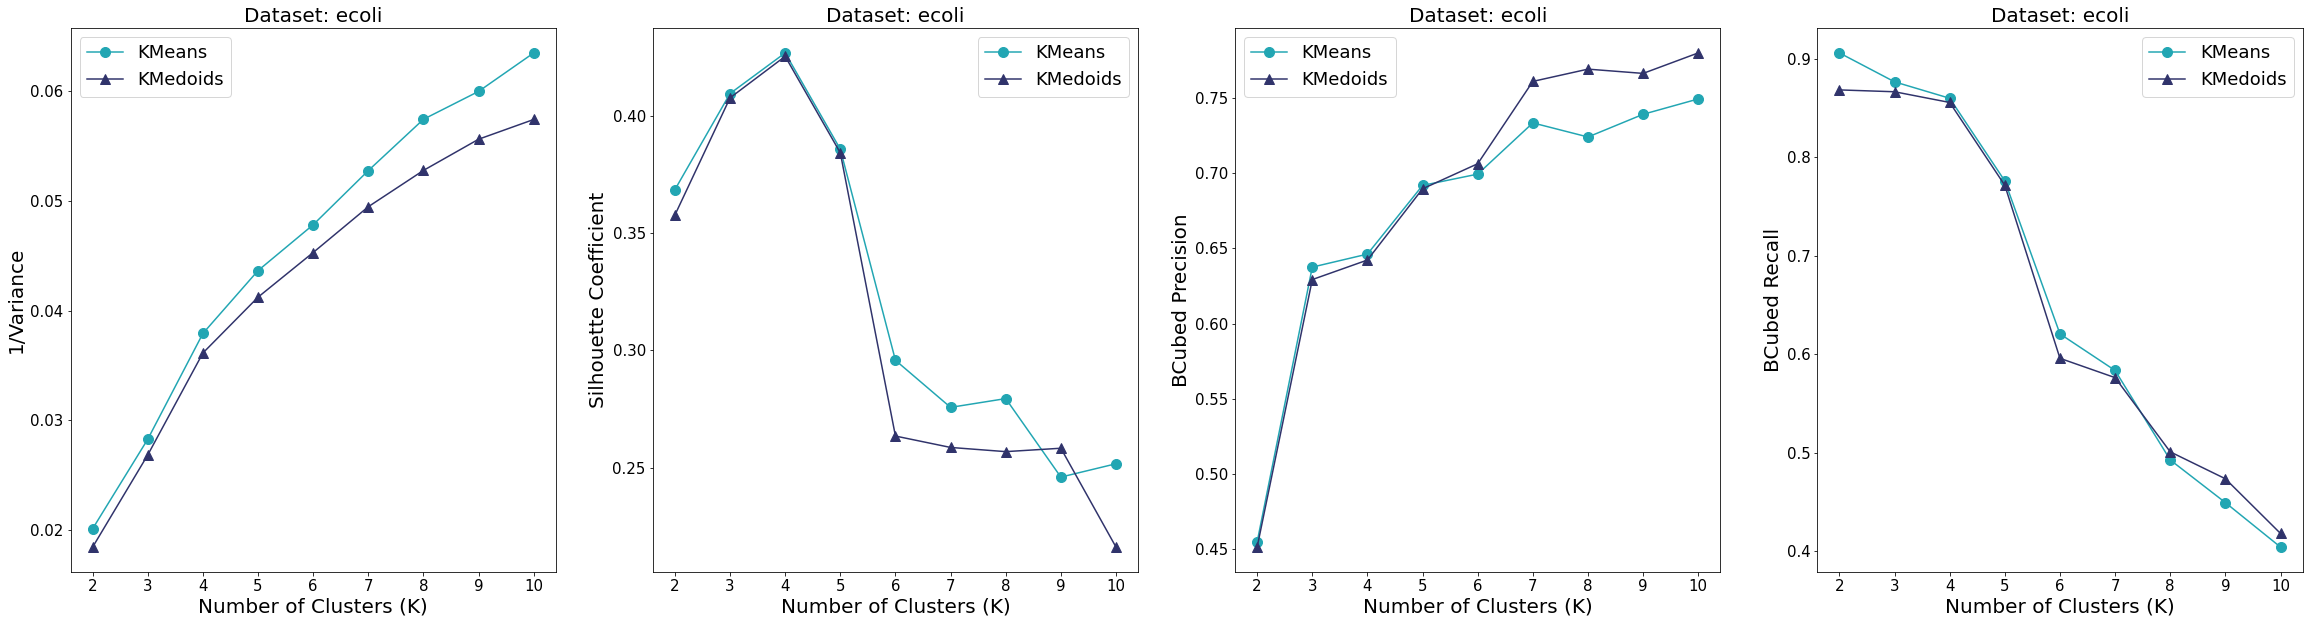

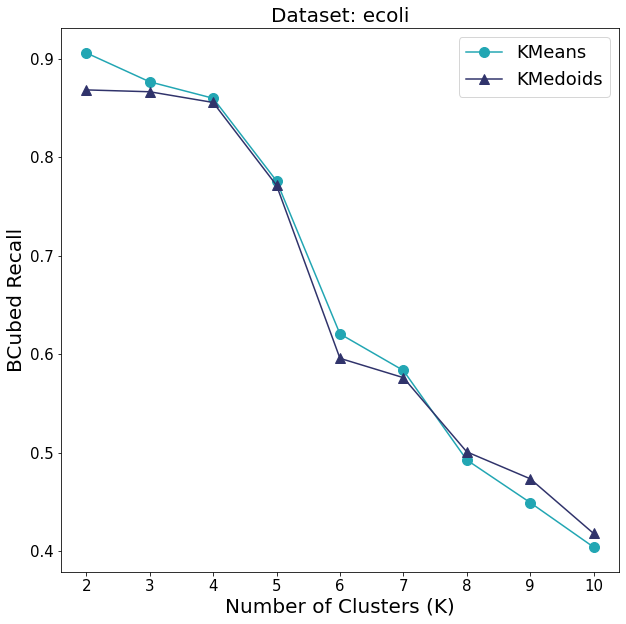

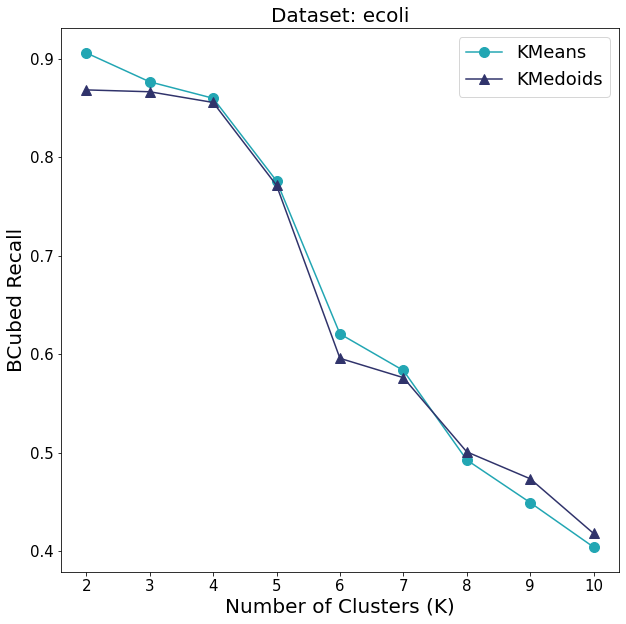

In [ ]:
dName = "ecoli"
df = pd.read_csv('/content/drive/My Drive/Thesis/Datasets/Ecoli/ecoli.data', sep= r'\s+',header=None)
X_df = df.iloc[:,1:-1]
Y_df = df.iloc[:,-1]
print('dataset: ecoli')
# print(X_df.head())
# print(Y_df.head())
print('instances = {}, features= {} '.format(X_df.shape[0], X_df.shape[1]))

X = X_df.fillna(X_df.mean()).to_numpy() 
Y = np.squeeze(Y_df.to_numpy())

measures = elbow_method(X, Y, maxK = 10, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
plot_elbow_curve(dName, measures, maxK = 10)
save_elbow_curve(dName, measures, maxK = 10, fileExtension='svg')
save_elbow_curve(dName, measures, maxK = 10, fileExtension='png')

In [ ]:
# kMeansMeasures, kMedoidsMeasures = clustering(X, Y, bestK = 3, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK=3, dName = dName)
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'svg')
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'png')

## Wholesale Customers

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185
dataset: wholesale_customers
instances = 440, features= 8 


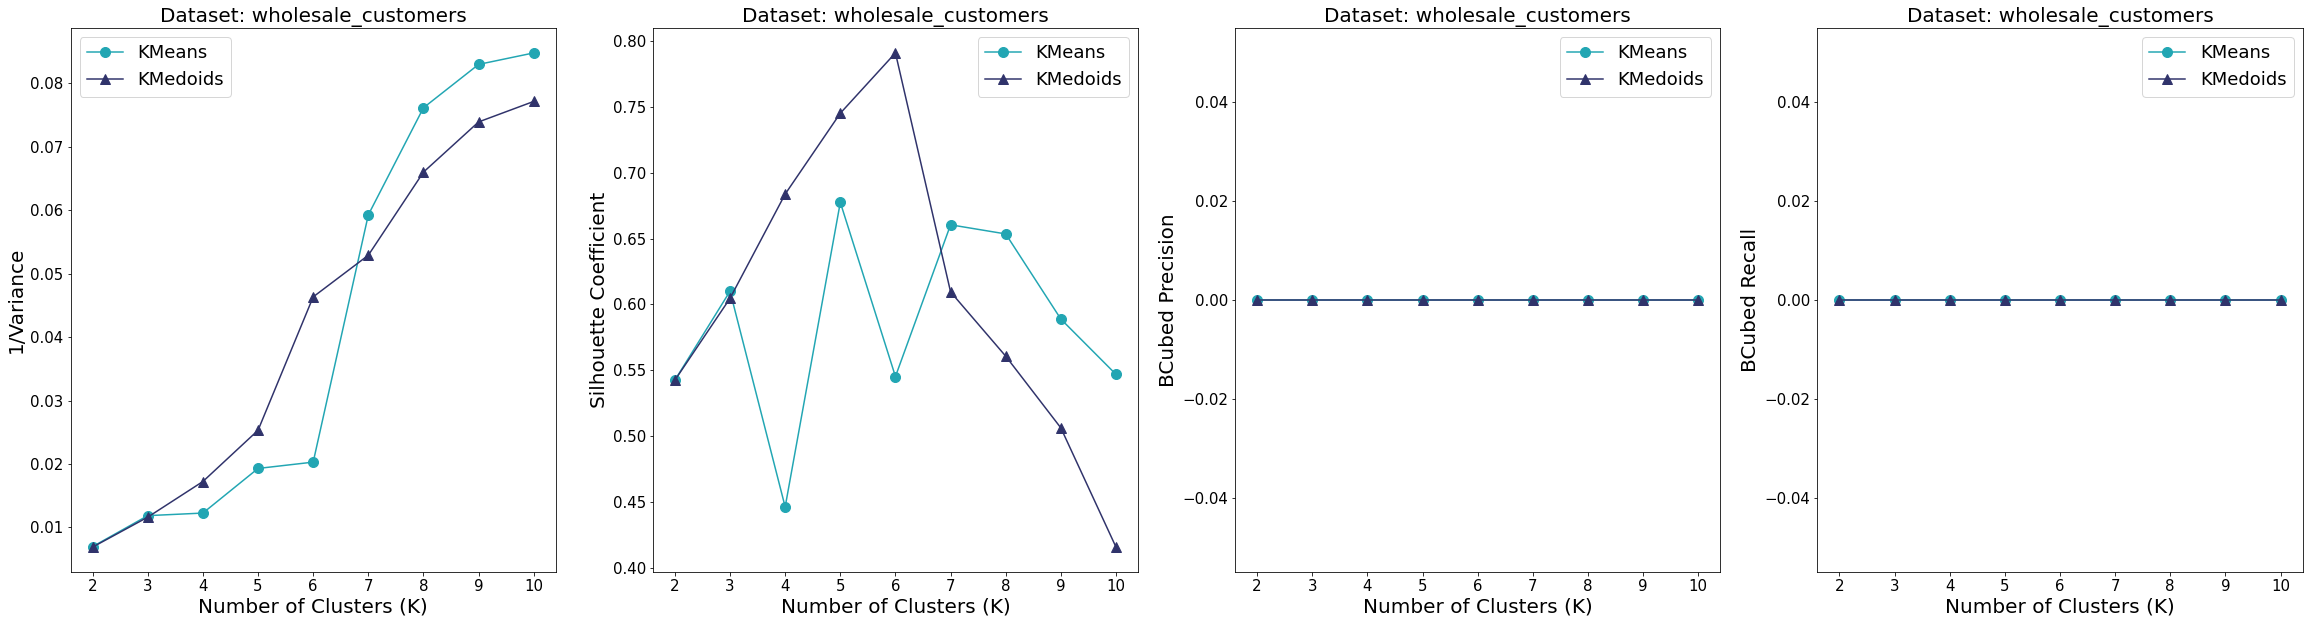

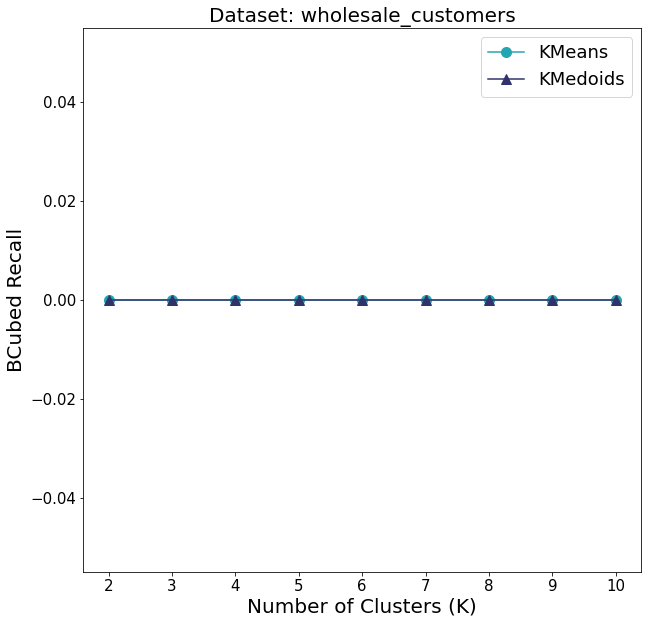

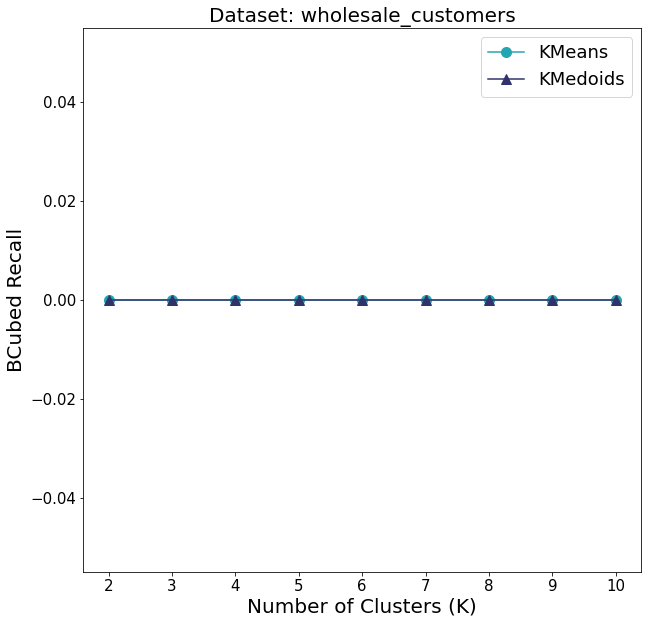

In [ ]:
dName = "wholesale_customers"
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Mining Assignments/Clustering/Datasets/wholesale_customers.csv', sep=',',header=0)
print(df.head())
X_df = df
print('dataset: wholesale_customers')
# print(X_df.head())
print('instances = {}, features= {} '.format(X_df.shape[0], X_df.shape[1]))

X = X_df.fillna(X_df.mean()).to_numpy() 
Y = np.array([])
attributeTypes = ['nominal', 'nominal', 'numerical', 'numerical', 'numerical', 'numerical', 'numerical', 'numerical']

measures = elbow_method(X, Y, maxK = 10, dataType="mixed", attributeTypes=attributeTypes, ranks = {}, numberOfIterations = 5)
plot_elbow_curve(dName, measures, maxK = 10)
save_elbow_curve(dName, measures, maxK = 10, fileExtension='svg')
save_elbow_curve(dName, measures, maxK = 10, fileExtension='png')

In [ ]:
# kMeansMeasures, kMedoidsMeasures = clustering(X, Y, bestK = 3, dataType="numerical", attributeTypes=[], ranks = {}, numberOfIterations = 5)
# plot_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK=3, dName = dName)
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'svg')
# # save_bar_chart(kMeansMeasures, kMedoidsMeasures, bestK = 3, dName = dName, fileExtension = 'png')